In [1]:
from Game import *

Version:  0.2.35


## Game functions

In [2]:
def initial_state():
    state=Board(3,3)
    state.pieces=[".","X","O"]
    return state

def show_state(state):
    print(state)
    
def valid_moves(state,player):
    # run through all the spots
    # if it is empty, then append that
    # location to the possible moves
    
    moves=[]
    for location in range(9):
        if state[location]==0:
            moves.append(location)
            
    return moves  

def update_state(state,player,move):
    new_state=state
    
    new_state[move]=player
    return new_state    
    
def win_status(state,player):
    # the state is *after* the move for the player

    #  0  1  2 
    #  3  4  5 
    #  6  7  8   
    
    for start,middle,end in [
        [0,1,2],[3,4,5],[6,7,8],
        [0,3,6],[1,4,7],[2,5,8],
        [0,4,8],[2,4,6],
                ]:
        
        if state[start]==player and state[middle]==player and state[end]==player:
            return "win"
        
    if player==1:
        other_player=2
    else:
        other_player=1
    
    if not valid_moves(state,other_player):
        return "stalemate"
    

## Agent Functions

In [3]:
def human_move(state,player):
    
    state.show_locations()
    print("Player",player)
    move=int(input("which square to move?"))
    return move

human_agent=Agent(human_move)     

In [4]:
def random_move(state,player):
    
    move=random.choice(valid_moves(state,player))
    return move


random_agent=Agent(random_move)

In [5]:
from Game.minimax import *
def minimax_move(state,player):

    values,moves=minimax_values(state,player,display=True)
    return top_choice(moves,values)


minimax_agent=Agent(minimax_move)

## Skittles Agent

In [6]:
def skittles_move(state,player,info):
    T=info.T
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    if state not in T:
        actions=valid_moves(state,player)
        T[state]=Table()
        for action in actions:
            T[state][action]=2  # initial number of skittles
    
    move=weighted_choice(T[state])
    
    if move is None:  
        
        # learn
        if learning:
            if last_state:
                T[last_state][last_action]-=1 # take away a skittle
                if T[last_state][last_action]<0:
                    T[last_state][last_action]=0
    
        return random_move(state,player)
    else:
        return move

In [7]:
def skittles_after(status,player,info):
    # not return anything but...
    # will adjust the skittles table if lost the game
    T=info.T
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    if learning:
        if status=='lose':  # only learn when you lose
            T[last_state][last_action]-=1 # take away a skittle
            if T[last_state][last_action]<0:
                T[last_state][last_action]=0

In [8]:
skittles1_agent=Agent(skittles_move)
skittles1_agent.post=skittles_after
skittles1_agent.T=Table()  # makes an empty table
skittles1_agent.learning=True

skittles2_agent=Agent(skittles_move)
skittles2_agent.post=skittles_after
skittles2_agent.T=Table()  # makes an empty table
skittles2_agent.learning=True

In [9]:
def Q_move(state,player,info):
    Q=info.Q
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    α=info.α  # learning rate
    ϵ=info.ϵ  # how often to take a random move
    γ=info.γ  # memory constant -- how quickly does the table update back in time (earlier in the game)
    
    # \alpha <hit tab>    α
    # \epsilon <hit tab>  ϵ
    # \gamma <hit tab>    γ
    
    if state not in Q:
        actions=valid_moves(state,player)
        Q[state]=Table()
        for action in actions:
            Q[state][action]=0  # initial value of table
    
    
    if random.random()<ϵ:  # take a random move occasionally to explore the environment
        move=random_move(state,player)
    else:
        move=top_choice(Q[state])
    
    if not last_action is None:  # not the first move
        reward=0
        
        # learn
        if learning:
            Q[last_state][last_action]+=α*(reward +
                        γ*max([Q[state][a] for a in Q[state]]) - Q[last_state][last_action])
    
    return move

In [10]:
def Q_after(status,player,info):
    Q=info.Q
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    α=info.α  # learning rate
    ϵ=info.ϵ  # how often to take a random move
    γ=info.γ  # memory constant -- how quickly does the table update back in time (earlier in the game)
    
    # \alpha <hit tab>    α
    # \epsilon <hit tab>  ϵ
    # \gamma <hit tab>    γ

    if status=='lose':
        reward=-1
    elif status=='win':
        reward=1
    elif status=='stalemate':
        reward=.5 # value stalemate a little closer to a win
    else:
        reward=0
    
    
    if learning:
        Q[last_state][last_action]+=α*(reward - Q[last_state][last_action])
        


In [22]:
Q1_agent=Agent(Q_move)
Q1_agent.post=Q_after
Q1_agent.Q=Table()  # makes an empty table
Q1_agent.learning=True

Q1_agent.α=0.3  # learning rate
Q1_agent.ϵ=0.1  # how often to take a random move
Q1_agent.γ=0.9  # memory constant -- how quickly does the table update back in time (earlier in the game)

Q2_agent=Agent(Q_move)
Q2_agent.post=Q_after
Q2_agent.Q=Table()  # makes an empty table
Q2_agent.learning=True

Q2_agent.α=0.3  # learning rate
Q2_agent.ϵ=0.1  # how often to take a random move
Q2_agent.γ=0.9  # memory constant -- how quickly does the table update back in time (earlier in the game)



## Running the Game

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

In [27]:
agent1=Q1_agent
agent2=Q2_agent

In [28]:
N_train=500
N_test=100
number_of_epochs=200
agent1_test=None
agent2_test=random_agent

In [29]:

iteration_count=0
percentage_won_player1=[]
percentage_won_player2=[]
percentage_tie=[]
number_of_iterations=[]

agent1.Q=LoadTable("2021-10-18 TTT Q1.json")
agent2.Q=LoadTable("2021-10-18 TTT Q2.json")

for i in tqdm(range(number_of_epochs)):

    agent1.learning=True
    agent2.learning=True

    g=Game(number_of_games=N_train)
    g.display=False
    result=g.run(agent1,agent2)


    if agent1_test is None:
        agent1_test=agent1
    if agent2_test is None:
        agent2_test=agent2

    # turn learning off to test
    agent1.learning=False
    agent2.learning=False

    g=Game(number_of_games=N_test)
    g.display=False
    result=g.run(agent1_test,agent2_test)
    iteration_count+=N_train

    percentage_won_player1.append(result.count(1)/N_test*100)
    percentage_won_player2.append(result.count(2)/N_test*100)
    percentage_tie.append(result.count(0)/N_test*100)
    number_of_iterations.append(iteration_count)


SaveTable(agent1.Q,"2021-10-18 TTT Q1.json")
SaveTable(agent2.Q,"2021-10-18 TTT Q2.json")    

100%|██████████| 200/200 [04:58<00:00,  1.49s/it]


Text(0, 0.5, 'Percentage Won')

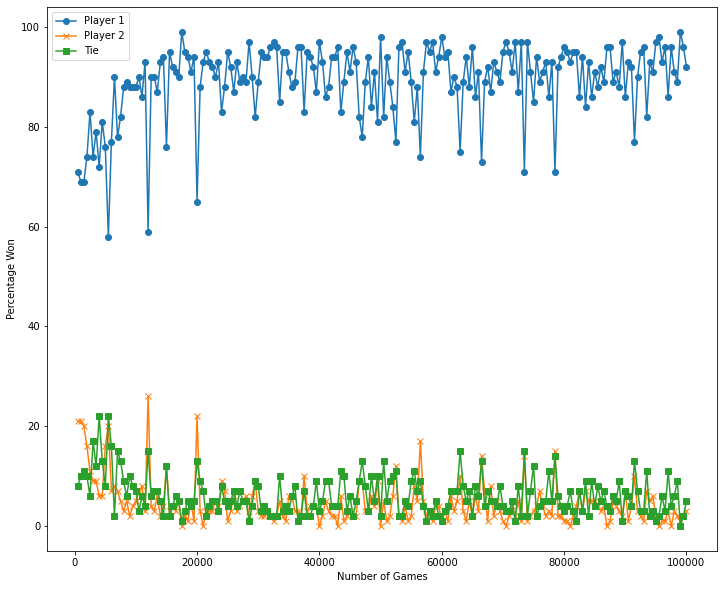

In [30]:
fig=plt.figure(figsize=(12,10))
h1=plt.plot(number_of_iterations,percentage_won_player1,'-o',label='Player 1')
h2=plt.plot(number_of_iterations,percentage_won_player2,'-x',label='Player 2')
h3=plt.plot(number_of_iterations,percentage_tie,'-s',label='Tie')
plt.legend()
plt.xlabel('Number of Games')
plt.ylabel('Percentage Won')    


## again, but I want to keep that figure above

In [31]:

iteration_count=0
percentage_won_player1=[]
percentage_won_player2=[]
percentage_tie=[]
number_of_iterations=[]

agent1.Q=LoadTable("2021-10-18 TTT Q1.json")
agent2.Q=LoadTable("2021-10-18 TTT Q2.json")

for i in tqdm(range(number_of_epochs)):

    agent1.learning=True
    agent2.learning=True

    g=Game(number_of_games=N_train)
    g.display=False
    result=g.run(agent1,agent2)


    if agent1_test is None:
        agent1_test=agent1
    if agent2_test is None:
        agent2_test=agent2

    # turn learning off to test
    agent1.learning=False
    agent2.learning=False

    g=Game(number_of_games=N_test)
    g.display=False
    result=g.run(agent1_test,agent2_test)
    iteration_count+=N_train

    percentage_won_player1.append(result.count(1)/N_test*100)
    percentage_won_player2.append(result.count(2)/N_test*100)
    percentage_tie.append(result.count(0)/N_test*100)
    number_of_iterations.append(iteration_count)


SaveTable(agent1.Q,"2021-10-18 TTT Q1.json")
SaveTable(agent2.Q,"2021-10-18 TTT Q2.json")    

100%|██████████| 200/200 [04:54<00:00,  1.47s/it]


Text(0, 0.5, 'Percentage Won')

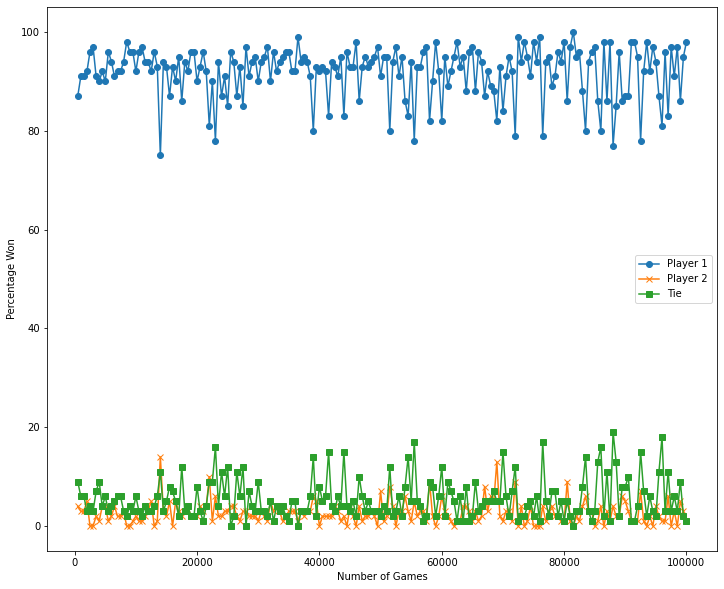

In [32]:
fig=plt.figure(figsize=(12,10))
h1=plt.plot(number_of_iterations,percentage_won_player1,'-o',label='Player 1')
h2=plt.plot(number_of_iterations,percentage_won_player2,'-x',label='Player 2')
h3=plt.plot(number_of_iterations,percentage_tie,'-s',label='Tie')
plt.legend()
plt.xlabel('Number of Games')
plt.ylabel('Percentage Won')    
